In [1]:
import matplotlib.pyplot as plt
import h5py
import numpy as np
import pickle

In [2]:
import pickle

snap_z = 2.00202813925285
id = '145492'

galaxy = pickle.load(open(f'data/galaxy_{id}.pck','rb'))

Calculate SED

In [3]:
from synthesizer.grid import Grid

grid_dir = '/Users/sw376/Dropbox/Research/data/synthesizer/grids/'
grid_name = 'bpass-2.2.1-bin_chabrier03-0.1,300.0_cloudy-c23.01-sps'
grid = Grid(grid_name, grid_dir=grid_dir, read_lines=False, new_lam=np.arange(1000., 7000., 10.))

In [4]:
sed = galaxy.stars.get_particle_spectra_reprocessed(grid)

----------
SUMMARY OF SED 
Number of wavelength points: 600 
Wavelength range: [1000.00 Å,             6990.00 Å] 
log10(Peak luminosity/erg/(Hz*s)):             26.68 
log10(Bolometric luminosity/erg/s):[38.4077989  38.29936966 37.94123082 ... 38.52346073 38.53903599
 38.5746702 ]----------


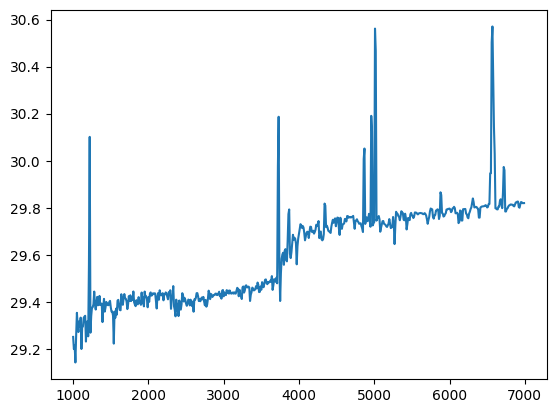

In [5]:
print(galaxy.stars.particle_spectra['incident'])

integrated_sed = sed.sum()

plt.plot(integrated_sed.lam, np.log10(integrated_sed.lnu))
plt.show()

In [6]:
from synthesizer.filters import UVJ, FilterCollection

# Get a UVJ filter set
# filters = UVJ(new_lam=grid.lam)

tophat_dict = {
    "B": {"lam_min": 1400, "lam_max": 1600},
    "G": {"lam_min": 4000, "lam_max": 6000},
    "R": {"lam_min": 6550, "lam_max": 6570},
}

tophat_dict = {
    "B": {"lam_min": 1400, "lam_max": 1600},
    "G": {"lam_min": 3000, "lam_max": 5000},
    "R": {"lam_min": 5000, "lam_max": 7000},
}

filters = FilterCollection(tophat_dict=tophat_dict, new_lam=grid.lam)

photometry = galaxy.stars.particle_spectra["reprocessed"].get_photo_luminosities(filters)


6.526925830282005e+29


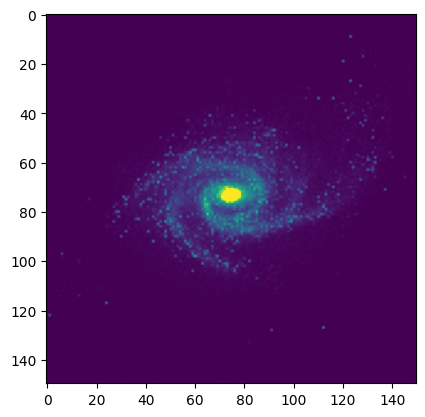

In [7]:

from unyt import kpc

fov = 40 * kpc
npix = 150
resolution = fov / npix

img = galaxy.get_images_luminosity(
    resolution=resolution,
    stellar_photometry="reprocessed",
    fov=fov,
)

print(np.sum(img.imgs['R'].arr))
# plt.imshow(np.log10(img.imgs['R'].arr))
plt.imshow(img.imgs['R'].arr, vmin = 0.0, vmax = 1E27)
plt.show()

# img.imgs['R'].arr /= (0.6)
# img.imgs['G'].arr /= (0.5)
# img.imgs['B'].arr /= (0.15)

img.imgs['R'].arr /= (0.5)
img.imgs['G'].arr /= (0.4)
img.imgs['B'].arr /= (0.15)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


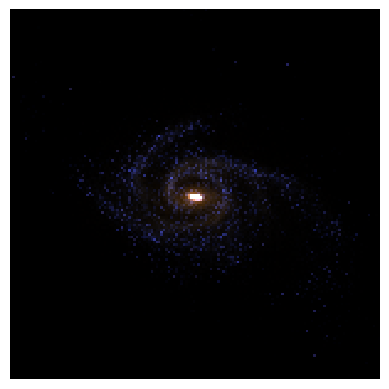

In [8]:
# Make and plot an rgb image
img.make_rgb_image(
    # rgb_filters={"R": "J", "G": "V", "B": "U"},
    rgb_filters={"R": "R", "G": "G", "B": "B"},
)
fig, ax, _ = img.plot_rgb_image(show=True, vmin=0., vmax=5E27)

fig.set_size_inches(1,1, forward=True)
ax.axis('off')
fig.savefig('rgb.png', dpi=100, bbox_inches='tight', pad_inches=0)

/Users/sw376/Dropbox/Research/projects/synthesizer/src/synthesizer/imaging/image.py:739: RuntimeWarning: divide by zero encountered in log10
  data = np.log10(data)


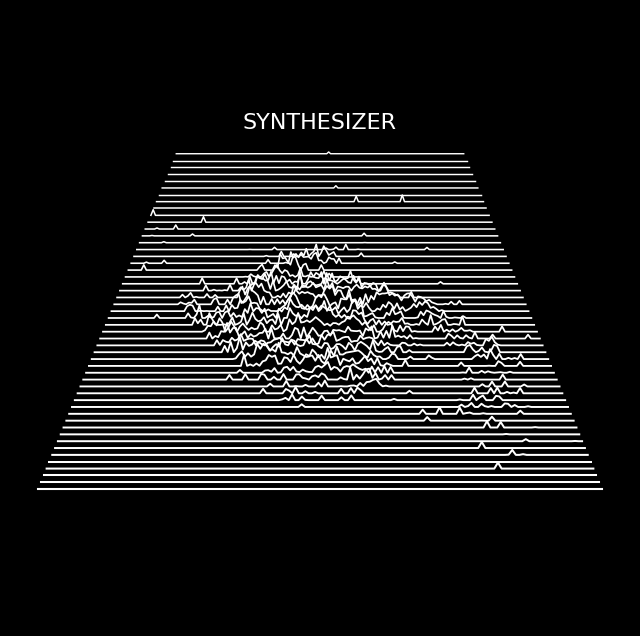

In [9]:
fig, ax = img.imgs['B'].plot_unknown_pleasures()
plt.show()